In [49]:
import random
import numpy as np
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from itertools import product

In [50]:
class Agent:
    def __init__(self, init_position = None):
        """
        Initialize an agent with a starting position and possible action set.
        
        Args:
            init_position (tuple): The (x, y) starting coordinates.
            actions (list): List of possible actions (e.g., ['stay', 'up','down','left','right']).
        """
        self.position = init_position  # Agent's (x, y) position on the grid.
        self.actions = ['stay', 'up', 'down', 'left', 'right']
        # Q-table: maps global state (all agents' positions + active reward target) to action values.
        self.q_table = {}
        
    def get_q_value(self, joint_state):
        """
        Retrieve the Q-value for the given joint state.
        """
        return self.q_table.get(joint_state, 0.0)

    def choose_joint_action(self, joint_state, env, epsilon=0.1):
        """
        Choose a joint action (a tuple of actions for all agents) using an epsilon–greedy strategy,
        based on the implicit Q-value representation.
        
        Args:
            joint_state: The current joint state.
            env (Environment): The environment which can simulate joint actions.
            epsilon (float): Exploration rate.
            
        Returns:
            joint_action (tuple): A tuple of actions (one per agent).
        """
        possible_joint_actions = list(product(self.actions, repeat=len(env.agents)))
        if random.random() < epsilon:
            return random.choice(possible_joint_actions)
        else:
            best_value = -float('inf')
            best_action = None
            for joint_action in possible_joint_actions:
                simulated_next_state = env.simulate_joint_action(joint_state, joint_action)
                q_val = self.get_q_value(simulated_next_state)
                if q_val > best_value:
                    best_value = q_val
                    best_action = joint_action
            if best_action is None:
                best_action = random.choice(possible_joint_actions)
            return best_action

    def update_q_value(self, current_state, reward, possible_next_states, alpha=0.1, gamma=0.99):
        """
        Update Q-value for the given joint state using the implicit (original) update rule.
        
        Args:
            current_state: The current joint state (tuple of each agent's state).
            reward (float): Immediate reward obtained in this transition.
            possible_next_states (list): All possible joint states achievable from current_state.
            alpha (float): Learning rate.
            gamma (float): Discount factor.
        """
        current_q = self.get_q_value(current_state)
        max_next = max([self.get_q_value(ns) for ns in possible_next_states] or [0.0])
        new_q = (1 - alpha) * current_q + alpha * (reward + gamma * max_next)
        self.q_table[current_state] = new_q


In [51]:
class BaseEnvironment:
    def __init__(self, grid_size, agents, target_rewards, together_reward, travel_reward):
        """
        Initialize the environment.
        
        Args:
            grid_size (tuple): (width, height) of the grid.
            n_agents (int): Number of agents in the environment.
            target_rewards (list): List of target rewards for each agent (e.g., [10, 10] for two agents).
            together_reward (float): Bonus reward if agents are at the same position.
            travel_reward (float): Penalty (energy cost) for each move.
        """
        self.grid_size = grid_size
        self.agents = agents # List of Agent instances.
        self.target_rewards = target_rewards
        self.together_reward = together_reward
        self.travel_reward = travel_reward
        
        # Active reward target managed by the environment.
        # It will be a tuple (like ('right','left')) or None if not active.
        self.active_reward_target = None
        self.possibilities = []
        
        # Center of the grid.
        self.center_pos = (grid_size[0] // 2, grid_size[1] // 2)
        
        # Mapping from reward identifiers to board coordinates.
        self.reward_place_to_coord = {
            (): (),
            ('up',): ((grid_size[0] // 2, grid_size[1] - 1),),
            ('right',): ((grid_size[0] - 1, grid_size[1] // 2),),
            ('down',): ((grid_size[0] // 2, 0),),
            ('left',): ((0, grid_size[1] // 2),),
            ('up','right'): ((grid_size[0] // 2, grid_size[1] - 1), (grid_size[0] - 1, grid_size[1] // 2)),
            ('right','down'): ((grid_size[0] - 1, grid_size[1] // 2), (grid_size[0] // 2, 0)),
            ('down','left'): ((grid_size[0] // 2, 0), (0, grid_size[1] // 2)),
            ('up','left'): ((0, grid_size[1] // 2), (grid_size[0] // 2, grid_size[1] - 1)),
            ('up','down'): ((grid_size[0] // 2, grid_size[1] - 1), (grid_size[0] // 2, 0)),
            ('right','left'): ((grid_size[0] - 1, grid_size[1] // 2), (0, grid_size[1] // 2)),
            # Additional mappings can be added as needed.
        }
        
        # For resetting when no rewards are collected over time.
        self.steps_without_reward = 0
        self.no_reward_threshold = 50

    def get_joint_state(self):
        """
        Return the joint state: a tuple of each agent's state.
        Each agent's state is represented as (position, active_reward_target).
        Since active_reward_target is the same for all, the joint state is:
        
            ((agent1_position, active_reward_target),
             (agent2_position, active_reward_target),
             ... )
        """
        return tuple((agent.position, self.active_reward_target) for agent in self.agents)

    def reset(self):
        """
        Reset agent positions randomly within the grid.
        Also clear the active reward target.
        """
        for agent in self.agents:
            agent.position = (random.randint(0, self.grid_size[0]-1),
                              random.randint(0, self.grid_size[1]-1))
        self.active_reward_target = None
        self.true_reward_target = random.choice(self.possibilities)

    def simulate_move(self, pos, action):
        """
        Simulate a move from a given position with an action.
        """
        moves = {
            'stay': (0, 0),
            'up':    (0, -1),
            'down':  (0, 1),
            'left':  (-1, 0),
            'right': (1, 0)
        }
        dx, dy = moves.get(action, (0, 0))
        new_x = max(0, min(self.grid_size[0]-1, pos[0] + dx))
        new_y = max(0, min(self.grid_size[1]-1, pos[1] + dy))
        return (new_x, new_y)
    
    def simulate_joint_action(self, joint_state, joint_actions):
        """
        Simulate the effect of a joint action on the given joint state.
        
        Args:
            joint_state: A tuple representing the current joint state.
            joint_actions: A tuple of actions (one per agent).
            
        Returns:
            next_joint_state: The simulated joint state after the joint actions.
        """
        new_states = []
        # Each joint state element is (position, active_reward_target)
        for ((pos, reward), action) in zip(joint_state, joint_actions):
            new_pos = self.simulate_move(pos, action)
            new_states.append((new_pos, reward))  # reward stays the same for simulation
        return tuple(new_states)
    
    def get_possible_next_states(self, joint_state):
        """
        Generate all possible next joint states from the current joint state.
        """
        possible_joint_actions = list(product(self.agents[0].actions, repeat=len(self.agents)))
        next_states = []
        for joint_action in possible_joint_actions:
            ns = self.simulate_joint_action(joint_state, joint_action)
            next_states.append(ns)
        return next_states
    
    def move_agents(self, joint_actions):
        """
        Update each agent's actual position according to the joint actions.
        """
        for idx, action in enumerate(joint_actions):
            pos = self.agents[idx].position
            self.agents[idx].position = self.simulate_move(pos, action)

    def step(self, joint_actions):
        """
        Execute one time step in the environment:
          1. Move agents according to their actions.
          2. Check for reward activation (e.g., an agent reaching the center).
          3. Check if agents are at the designated reward positions.
          4. Apply travel penalty and together bonus.
          5. Reset if no reward is collected for too long.
        
        Args:
            actions (list): List of actions, one per agent.
            
        Returns:
            observations (list): Each agent's observed global state.
            rewards (list): Reward for each agent.
        """
        # 1. Move agents.
        self.move_agents(joint_actions)
        joint_state = self.get_joint_state()
        rewards = [0 for _ in self.agents]
        
        # 2. Check for reward activation if none is active.
        self.check_and_activate_rewards()
        
        # 3. Compute rewards based on agent positions and active reward target.
        collected = self.compute_rewards(rewards)
        
        # 4. Add together bonus if all agents are at the same position.
        if len(set(agent.position for agent in self.agents)) == 1:
            rewards = [r + self.together_reward for r in rewards]
        
        # 5. Add travel (energy loss) penalty.
        rewards = [r + self.travel_reward for r in rewards]
        
        # Update no-reward counter.
        if not collected:
            self.steps_without_reward += 1
        else:
            self.steps_without_reward = 0
        
        # 6. If no reward is collected for too long, reset agents and active reward target.
        if self.steps_without_reward > self.no_reward_threshold:
            self.reset()
            self.steps_without_reward = 0
        
        # Return the new global state as observation for all agents.
        new_joint_state = self.get_joint_state()
        observations = [new_joint_state for _ in self.agents]
        return observations, rewards, {}

    def check_and_activate_rewards(self):
        """
        Check if any agent is at the center and no reward target is active.
        If so, activate the reward target.
        This method is meant to be overridden by regime-specific environments.
        """
        if self.active_reward_target is None:
            for agent in self.agents:
                if agent.position == self.center_pos:
                    self.active_reward_target = self.true_reward_target
                    break

    def compute_rewards(self, rewards):
        """
        Compute rewards based on agent positions and active reward target.
        Modify the rewards list in place.
        Returns:
            collected (bool): True if the reward has been collected.
        This method is meant to be overridden by regime-specific environments.
        """
        collected = False
        if self.active_reward_target:
            coords = self.reward_place_to_coord.get(self.true_reward_target, ())
            for reward_coord in coords:
                if all(agent.position == reward_coord for agent in self.agents):
                    for i in range(len(rewards)):
                        rewards[i] += self.target_rewards[i]
                    collected = True
                    break
        if collected:
            self.active_reward_target = None
        return collected

class EnvironmentRegime0(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        # Fixed reward target for regime 0.
        self.possibilities = [()]
        self.reset()

    def check_and_activate_rewards(self):
        # In regime 0, we do not need to activate a reward zone.
        pass
        
    def compute_rewards(self, rewards):
        collected = False
        if any(agent.position == self.center_pos for agent in self.agents):
            for i in range(len(rewards)):
                rewards[i] += self.target_rewards[i]
            collected = True
        return collected

class EnvironmentRegime1(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        self.possibilities = [('right', 'left')]
        self.reset()

class EnvironmentRegime2(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        self.possibilities = [('up', 'down')]
        self.reset()

class EnvironmentRegime3(BaseEnvironment):
    def __init__(self, grid_size, n_agents, target_rewards, together_reward, travel_reward):
        super().__init__(grid_size, n_agents, target_rewards, together_reward, travel_reward)
        self.possibilities = [
            ('up', 'right'),
            ('right', 'down'),
            ('down', 'left'),
            ('up', 'left'),
            ('right', 'left'),
            ('up', 'down')
        ]
        self.reset()

In [52]:
class Trainer:
    def __init__(self, env, num_steps, epsilon_start, epsilon_end):
        """
        Initialize the trainer.
        
        Args:
            env (BaseEnvironment): An instance of a regime-specific environment.
            num_steps (int): Total number of training steps.
            epsilon_start (float): Initial exploration rate.
            epsilon_end (float): Final exploration rate.
        """
        self.env = env
        self.num_steps = num_steps
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end

    def train(self, alpha=0.1, gamma=0.99, verbose=True):
        """
        Run the training loop.
        
        Returns:
            history (dict): Collected reward history per agent.
        """
        history = {i: [] for i in range(len(self.env.agents))}
        current_state = self.env.get_joint_state()
        joint_agent = self.env.agents[0]
        
        for step in tqdm(range(self.num_steps), disable=not verbose):
            # Linearly decay epsilon.
            epsilon = ((self.epsilon_end - self.epsilon_start) / self.num_steps) * step + self.epsilon_start
            
            # Each agent chooses an action based on the global state.
            joint_action = joint_agent.choose_joint_action(current_state, self.env, epsilon)
            
            # Environment processes the actions.
            observations, rewards, info = self.env.step(joint_action)
            next_state = observations[0]  # global state (same for all agents)
            
            possible_next_states = self.env.get_possible_next_states(current_state)
            
            # Each agent updates its Q-table.
            for i, agent in enumerate(self.env.agents):
                agent.update_q_value(current_state, rewards[i], possible_next_states, alpha, gamma)
                history[i].append(rewards[i])
            current_state = next_state
        return history

In [53]:
# Agents
n_agents = 2
target_rewards = [20] * n_agents  # Reward for each agent when target is met
agents = [Agent() for _ in range(n_agents)] 

# Parameters for the grid and rewards
grid_size = (5, 5)
together_reward = 0      # No bonus if agents are together
travel_reward = -1       # Penalty for movement
num_steps = 1_000
epsilon_start = 0.99
epsilon_end = 0.4 # 0.4

# Training parameters
alpha = 0.1 # 0.1 # Learning rate
gamma = 0.9

# List the environments and train sequentially.
environments = [EnvironmentRegime0, EnvironmentRegime1, EnvironmentRegime2, EnvironmentRegime3]
# environments = [EnvironmentRegime3]
rrh = [] # Reward history for each regime
for i, e in enumerate(environments):
    print(f"--- Training in Environment Regime {i} ---")
    # Create one environment per regime.
    env = e(grid_size, agents, target_rewards, together_reward, travel_reward)
    print(len(env.agents[0].q_table))
    trainer = Trainer(env, num_steps, epsilon_start, epsilon_end)
    reward_history = trainer.train(alpha=alpha, gamma=gamma)
    rrh.append(reward_history)


--- Training in Environment Regime 0 ---
0


100%|██████████| 1000/1000 [00:00<00:00, 14376.66it/s]


--- Training in Environment Regime 1 ---
335


100%|██████████| 1000/1000 [00:00<00:00, 24169.37it/s]


--- Training in Environment Regime 2 ---
779


100%|██████████| 1000/1000 [00:00<00:00, 25789.68it/s]


--- Training in Environment Regime 3 ---
1239


100%|██████████| 1000/1000 [00:00<00:00, 23337.60it/s]


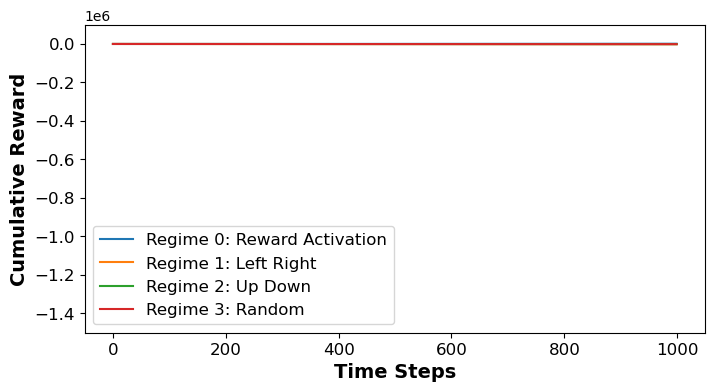

In [54]:
plt.figure(figsize=(8, 4))
regime_names = ['Regime 0: Reward Activation', 'Regime 1: Left Right', 'Regime 2: Up Down', 'Regime 3: Random']
for regime, reward_history in enumerate(rrh):
    rh = np.array(reward_history[0])
    crh = np.cumsum(rh, axis=0)
    plt.plot(crh, label=regime_names[regime])
plt.legend(fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-1.5e6, 0.1e6)
plt.legend(loc="lower left", fontsize=12)
plt.show()